In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
from salishsea_tools import viz_tools
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
import cmocean
from salishsea_tools import viz_tools, grid_tools, evaltools as et
import NorthNut as nn
import matplotlib.gridspec as gridspec
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


In [2]:
### want 6th T cell (5.5m) and the w level under it (6m):
kT=5
kW=6

In [3]:
# compile ssh
start=dt.datetime(2015,4,1) # make sure start and end are consistent between hindcast and GLS files
end=dt.datetime(2015,10,1) # end quickly for now- calculations too long
GLSstart=dt.datetime(2015,5,1)
GLSend=dt.datetime(2015,7,19)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_basedir_GLS='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/GLS_Summer15/'
mod_nam_fmt='nowcast'
mod_nam_fmt_GLS='long'
mod_flen=1
mod_flen_GLS=10
saveloc='/ocean/eolson/MEOPAR/northernNO3PaperCalcs/notebooks/Movie/files/'
fver='HC201812'

In [4]:
fliste3t=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'carp_T',1)
flistT=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)
flistW=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_W',1)
flistP=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistNU=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_U',1)
flistNV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_V',1)
flistNW=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_W',1)
#flistU=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_U',1)
#flistV=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_V',1)
flistGW=et.index_model_files(GLSstart,GLSend,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'dian_W',1)
#flistB=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'nbio_T',1)
#flistR=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'npro_T',1)
#flistP=et.index_model_files(start,end,mod_basedir_GLS,mod_nam_fmt_GLS,mod_flen_GLS,'nphy_T',1)

ftype=dian_U, are you sure? (if yes, add to list)
ftype=dian_V, are you sure? (if yes, add to list)
ftype=dian_W, are you sure? (if yes, add to list)
ftype=dian_W, are you sure? (if yes, add to list)


In [5]:
baseDirWind='/results/forcing/atmospheric/GEM2.5/operational/'
flistWind=et.index_model_files(start,end,baseDirWind,'wind',1,'None',1)
windWeights='/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/weights-gem2.5-ops_201702.nc'

In [6]:
jsshNN,isshNN=(115,13)
jssh,issh=(nn.jg0+115,nn.ig0+13)

In [7]:
sti1=list()
tc_i=list()
for iif in range(0,len(flistT)):
    #print('iif=',iif)
    with nc.Dataset(flistT.loc[iif,['paths']].values[0]) as fT:
        # extract fields to numpy variables for faster transect extraction:
        sti1.append(fT.variables['sossheig'][:,jssh,issh])
        tc_i.append(fT.variables['time_centered'][:])
st1=np.concatenate(sti1,axis=0)
tc=np.concatenate(tc_i,axis=0)
del sti1, tc_i
tcdt=[dt.datetime(1900,1,1)+dt.timedelta(seconds=tc[ii]) for ii in range(0,len(tc))]

In [8]:
mapCol=(0.67, 0.8, 0.64) # rgb
cm0=mpl.cm.get_cmap('Oranges')
cm0.set_bad(mapCol)
cm1=cmocean.cm.ice
cm1.set_bad(mapCol)
cmb=cmocean.tools.crop_by_percent(cmocean.cm.balance, 45, which='both', N=None)
cmb.set_bad(mapCol)
cmd=cmocean.tools.crop_by_percent(cmocean.cm.curl, 45, which='both', N=None)
cmd.set_bad(mapCol)
cmc=cmocean.tools.crop_by_percent(cmocean.cm.tarn_r, 40, which='both', N=None)
cmc.set_bad(mapCol)
cmp=cmocean.cm.matter
cmp.set_bad(mapCol)

In [9]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=mesh.variables['tmask'][:,...]
    umask=mesh.variables['umask'][:,...]
    vmask=mesh.variables['vmask'][:,...]
    e1t=mesh.variables['e1t'][:,...]
    e2t=mesh.variables['e2t'][:,...]
    e1v=mesh.variables['e1v'][:,...]
    e2v=mesh.variables['e2v'][:,...]
    e1u=mesh.variables['e1u'][:,...]
    e2u=mesh.variables['e2u'][:,...]
    e3t_0=mesh.variables['e3t_0'][:,...]
    e3v_0=mesh.variables['e3v_0'][:,...]
    e3u_0=mesh.variables['e3u_0'][:,...]
Ak=nn.tmask[kW,:,:]*e1t[0,nn.jg0:nn.jg1,nn.ig0:nn.ig1]*e2t[0,nn.jg0:nn.jg1,nn.ig0:nn.ig1]

In [27]:
flh=mod_flen*24
flhGLS=mod_flen_GLS*24

In [15]:
(GLSstart-start).total_seconds()/3600

720.0

In [18]:
np.floor(.5)

0.0

In [34]:
def makefig(iii):
    iif=int(iii/flh)
    iiiG=int(iii-(GLSstart-start).total_seconds()/3600)
    iifG=int(np.floor(iiiG/flhGLS))
    idate=start+dt.timedelta(hours=iii)
    
    fig = plt.figure(figsize=(8.5,6.))
    gs0 = gridspec.GridSpec(2,4,hspace=0.25,wspace=.25,left=.03,right=.95,
                        bottom=.205,top=.93,width_ratios=[1,1,1,1],height_ratios=[1,1])
    gs1=dict()
    pax=list()
    cbax=list()
    for igs in range(0,8):
        gs1[igs]=gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec=gs0[int(igs/4),igs%4],width_ratios=[10,1],wspace=.1)
        pax.append(fig.add_subplot(gs1[igs][0,0]))
        cbax.append(fig.add_subplot(gs1[igs][0,1]))
        #pax[igs].pcolormesh(nn.tmask[0,:,:])
        pax[igs].set_aspect(5/4.4)
        pax[igs].get_xaxis().set_visible(False)
        pax[igs].get_yaxis().set_visible(False)
        pax[igs].set_facecolor(mapCol)
    ax=pax[0]; cba=cbax[0]
    clim=(0,30)
    with nc.Dataset(flistP.loc[iif,['paths']].values[0]) as fP:
        mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,fP.variables['nitrate'][iii%flh,0,nn.jg0:nn.jg1,nn.ig0:nn.ig1]),
                          np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cm0,extend='max')
    cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],6))
    ax.set_title('Surface\nNO$_3$ ($\muup$M N)')

    ax=pax[1]; cba=cbax[1]
    clim=(-.2,.2)
    with nc.Dataset(flistW.loc[iif,['paths']].values[0]) as fW:
        mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,100*fW.variables['vovecrtz'][iii%flh,kW,nn.jg0:nn.jg1,nn.ig0:nn.ig1]),
                          np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmb,extend='both')
    cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],5))
    ax.set_title('Relative\nVertical Velocity (cm s$^{-1}$)')

    ax=pax[3]; cba=cbax[3]
    clim=(-8,8)
    with nc.Dataset(flistNW.loc[iif,['paths']].values[0]) as fNW:
        mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,1e3*fNW.variables['VMIXNO3'][iii%flh,kW,:,:]),
                          np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmb,extend='both') # check units
    cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],5))
    ax.set_title('Vertical NO$_3$ Flux,\nMixing ($\muup$mol N m$^{-2}$ s$^{-1}$)') 

    ax=pax[2]; cba=cbax[2]
    clim=(-20,20)
    with nc.Dataset(flistNW.loc[iif,['paths']].values[0]) as fNW:
        mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,1e3*fNW.variables['NO3_WT'][iii%flh,kW,:,:])/Ak,
                          np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmb,extend='both')
    cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],5))
    ax.set_title('Vertical NO$_3$ Flux,\nAdvection ($\muup$mol N m$^{-2}$ s$^{-1}$)')

    ax=pax[4]; cba=cbax[4]
    mat,ns=grid_tools.build_matrix(windWeights,flistWind.loc[iif,['paths']].values[0])
    uwnd=grid_tools.use_matrix(flistWind.loc[iif,['paths']].values[0],mat,ns,'u_wind',iii%flh)
    vwnd=grid_tools.use_matrix(flistWind.loc[iif,['paths']].values[0],mat,ns,'v_wind',iii%flh)
    ugrd,vgrd=viz_tools.rotate_vel(uwnd,vwnd,origin='map')
    clim=(0,15)
    subW=9
    meshWind=ax.contourf(np.ma.masked_where(tmask[0,0,nn.jg0:nn.jg1,nn.ig0:nn.ig1]==0,
                        np.sqrt(ugrd[nn.jg0:nn.jg1,nn.ig0:nn.ig1]**2+vgrd[nn.jg0:nn.jg1,nn.ig0:nn.ig1]**2)),
                         np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],
                               cmap=cm1,extend='both')
    cb=fig.colorbar(meshWind,cax=cba,ticks=np.linspace(clim[0],clim[1],6))
    sh=np.shape(tmask[0,0,nn.jg0:nn.jg1,nn.ig0:nn.ig1])
    shxW,shyW=np.meshgrid(np.arange(0,sh[1],subW),np.arange(0,sh[0],subW))
    Qw = ax.quiver(shxW,shyW,ugrd[nn.jg0:nn.jg1:subW, nn.ig0:nn.ig1:subW], vgrd[nn.jg0:nn.jg1:subW, nn.ig0:nn.ig1:subW],
                   pivot='mid', units='inches',width=.02)
    ax.set_title('Wind Velocity\n(m/s)')

    ax=pax[5]; cba=cbax[5]
    clim=(0,5)
    subN=9
    with nc.Dataset(flistNV.loc[iif,['paths']].values[0]) as fNV, \
         nc.Dataset(flistNU.loc[iif,['paths']].values[0]) as fNU, \
         nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3:
        e3t=fe3.variables['e3t'][iii%24,:,nn.jg0:nn.jg1,nn.ig0:nn.ig1]
        #e3v=vvl_interp_T_to_V(e3t[:,:kW,:,:],e1v,e2v,e1t,e2t,vmask[:,:kW,:,:],e3t_0[:,:kW,:,:],e3v_0[:,:kW,:,:])
        #ie13v=e3v*e1v
        #e3u=vvl_interp_T_to_U(e3t[:,:kW,:,:],e1u,e2u,e1t,e2t,umask[:,:kW,:,:],e3t_0[:,:kW,:,:],e3u_0[:,:kW,:,:])
        #ie23u=e3u*e2u
        ie13t=np.sum(e3t[:kW,1:,1:],0)*e1t[0,(nn.jg0+1):nn.jg1,(nn.ig0+1):nn.ig1]
        ie23t=np.sum(e3t[:kW,1:,1:],0)*e2t[0,(nn.jg0+1):nn.jg1,(nn.ig0+1):nn.ig1]
        TVt=0.5*(np.sum(fNV.variables['NO3_VT'][iii%24,:kW,:-1,1:],0)+\
                 np.sum(fNV.variables['NO3_VT'][iii%24,:kW,1:,1:],0))/ie13t
        TUt=0.5*(np.sum(fNU.variables['NO3_UT'][iii%24,:kW,1:,:-1],0)+\
                 np.sum(fNU.variables['NO3_UT'][iii%24,:kW,1:,1:],0))/ie23t
    sh=np.shape(TVt)
    shx,shy=np.meshgrid(np.arange(1,sh[1],subN),np.arange(1,sh[0],subN))
    #log scale arrow magnitude without ruining vector directions:
    ugrd=TUt
    vgrd=TVt
    mesh=ax.contourf(np.ma.masked_where(nn.tmask[0,1:,1:]==0,
        np.sqrt(ugrd[:,:]**2+vgrd[:,:]**2)),
        np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cm0,extend='max')
    cb=fig.colorbar(mesh,cax=cba,ticks=np.linspace(clim[0],clim[1],6))
    mag0=np.sqrt(ugrd**2+vgrd**2)
    #mag2=np.log10(mag0+100)-np.log10(100)
    ugrd2=np.ma.masked_where(nn.tmask[0,1:,1:]==0,ugrd)#np.where(mag0==0,0,ugrd*mag2/mag0))
    vgrd2=np.ma.masked_where(nn.tmask[0,1:,1:]==0,vgrd)#np.where(mag0==0,0,vgrd*mag2/mag0))
    Q = ax.quiver(shx,shy,ugrd2[1::subN, 1::subN], vgrd2[1::subN, 1::subN],
                                   pivot='mid', units='inches',width=.03,color='w',scale=30,alpha=.7)#scale=4000
    ax.set_title('Horizontal NO$_3$\nFlux (mol N/m$^2$/d)')

    if (iifG>=0) & (iifG<len(flistGW)): 
        ax=pax[6]; cba=cbax[6]
        clim=(-8,-5)
        with nc.Dataset(flistGW.loc[iifG,['paths']].values[0]) as fGW:
            temp1=np.where(fGW.variables['GLS_P'][iiiG%flhGLS,kW,:,:]==0,1e-9,fGW.variables['GLS_P'][iiiG%flhGLS,kW,:,:])
            mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,np.log10(temp1)),
                              np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
        cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-6.5, clim[1]])
        cb.ax.set_yticklabels(['1e-8', '1e-6.5', '1e-5'])
        ax.set_title('Shear Production (m$^2$s$^3$)') 

        ax=pax[7]; cba=cbax[7]
        clim=(-5,-3)
        with nc.Dataset(flistGW.loc[iifG,['paths']].values[0]) as fGW:
            temp=np.where(fGW.variables['GLS_k'][iiiG%flhGLS,kW,:,:]==0,1e-9,fGW.variables['GLS_k'][iiiG%flhGLS,kW,:,:])
            mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,np.log10(temp)),
                              np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
        cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-4, clim[1]])
        cb.ax.set_yticklabels(['1e-5', '1e-4', '1e-3'])
        ax.set_title('TKE (m$^2$s$^2$)') 
    else:
        temp=np.ones(np.shape(nn.tmask[kW,:,:]))
        ax=pax[6]; cba=cbax[6]
        clim=(-8,-5)
        mesh0=ax.contourf(np.ma.masked_where(temp==1,temp),
                        np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
        cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-6.5, clim[1]])
        cb.ax.set_yticklabels(['1e-8', '1e-6.5', '1e-5'])
        ax.set_title('Shear Production (m$^2$s$^3$)') 
        ax=pax[7]; cba=cbax[7]
        clim=(-5,-3)
        mesh0=ax.contourf(np.ma.masked_where(temp==1,temp),
                        np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
        cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-4, clim[1]])
        cb.ax.set_yticklabels(['1e-5', '1e-4', '1e-3'])
        ax.set_title('TKE (m$^2$s$^2$)')

    sshax=fig.add_axes([.07,.05,.88,.09])
    sshax.plot(tcdt,st1,'k-',lw=.5)
    sshax.plot(tcdt[iii],st1[iii],'ro')
    yearsFmt = mdates.DateFormatter('%b %d')
    sshax.xaxis.set_major_formatter(yearsFmt)
    sshax.xaxis.set_ticks([dt.datetime(2015,4,1), dt.datetime(2015,4,15),dt.datetime(2015,5,1), dt.datetime(2015,5,15),
                           dt.datetime(2015,6,1),dt.datetime(2015,6,15),dt.datetime(2015,7,1),dt.datetime(2015,7,15),
                           dt.datetime(2015,8,1),dt.datetime(2015,8,15),dt.datetime(2015,9,1),dt.datetime(2015,9,15),dt.datetime(2015,10,1)]);
    sshax.set_xlim((dt.datetime(2015,4,1),dt.datetime(2015,10,1)))
    sshax.set_ylim(-2.5,2)
    sshax.set_yticks((-2,0,2))
    sshax.set_title('Sea Surface Height in Discovery Passage')
    sshax.set_ylabel('SSH (m)')
    
    #sshax.annotate(idate.strftime('%Y-%m-%d'),xy=(.5, .96), xycoords='figure fraction',
    #        horizontalalignment='center', verticalalignment='bottom')
    fig.savefig('./files/movie_'+format(iii, "04d")+'.png',dpi=100)

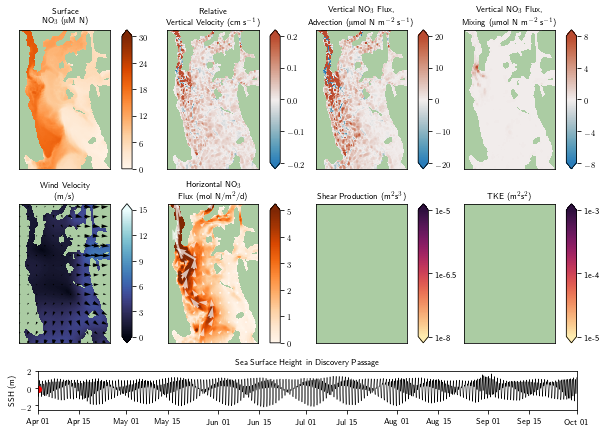

In [35]:
makefig(0)

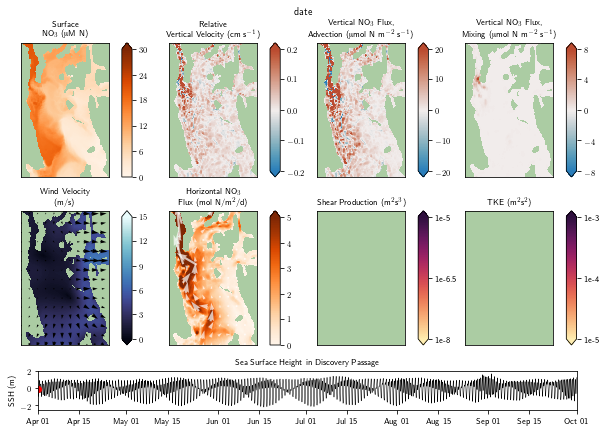

In [23]:
fig = plt.figure(figsize=(8.5,6.))
gs0 = gridspec.GridSpec(2,4,hspace=0.25,wspace=.25,left=.03,right=.95,
                        bottom=.2,top=.9,
                      width_ratios=[1,1,1,1],height_ratios=[1,1])
gs1=dict()
pax=list()
cbax=list()
for igs in range(0,8):
    gs1[igs]=gridspec.GridSpecFromSubplotSpec(1,2,
        subplot_spec=gs0[int(igs/4),igs%4],width_ratios=[10,1],wspace=.1)
    pax.append(fig.add_subplot(gs1[igs][0,0]))
    cbax.append(fig.add_subplot(gs1[igs][0,1]))
    #pax[igs].pcolormesh(nn.tmask[0,:,:])
    pax[igs].set_aspect(5/4.4)
    pax[igs].get_xaxis().set_visible(False)
    pax[igs].get_yaxis().set_visible(False)
    pax[igs].set_facecolor(mapCol)
iii=0#30*24
iif=0#30
iifG=-20
iiiG=-20
ax=pax[0]; cba=cbax[0]
clim=(0,30)
with nc.Dataset(flistP.loc[iif,['paths']].values[0]) as fP:
    mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,fP.variables['nitrate'][iii%24,0,nn.jg0:nn.jg1,nn.ig0:nn.ig1]),
                      np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cm0,extend='max')
cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],6))
ax.set_title('Surface\nNO$_3$ ($\muup$M N)')

ax=pax[1]; cba=cbax[1]
clim=(-.2,.2)
with nc.Dataset(flistW.loc[iif,['paths']].values[0]) as fW:
    mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,100*fW.variables['vovecrtz'][iii%24,kW,nn.jg0:nn.jg1,nn.ig0:nn.ig1]),
                      np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmb,extend='both')
cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],5))
ax.set_title('Relative\nVertical Velocity (cm s$^{-1}$)')

ax=pax[3]; cba=cbax[3]
clim=(-8,8)
with nc.Dataset(flistNW.loc[iif,['paths']].values[0]) as fNW:
    mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,1e3*fNW.variables['VMIXNO3'][iii%24,kW,:,:]),
                      np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmb,extend='both') # check units
cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],5))
ax.set_title('Vertical NO$_3$ Flux,\nMixing ($\muup$mol N m$^{-2}$ s$^{-1}$)') 

ax=pax[2]; cba=cbax[2]
clim=(-20,20)
with nc.Dataset(flistNW.loc[iif,['paths']].values[0]) as fNW:
    mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,1e3*fNW.variables['NO3_WT'][iii%24,kW,:,:])/Ak,
                      np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmb,extend='both')
cb=fig.colorbar(mesh0,cax=cba,ticks=np.linspace(clim[0],clim[1],5))
ax.set_title('Vertical NO$_3$ Flux,\nAdvection ($\muup$mol N m$^{-2}$ s$^{-1}$)')

ax=pax[4]; cba=cbax[4]
mat,ns=grid_tools.build_matrix(windWeights,flistWind.loc[iif,['paths']].values[0])
uwnd=grid_tools.use_matrix(flistWind.loc[iif,['paths']].values[0],mat,ns,'u_wind',iii%24)
vwnd=grid_tools.use_matrix(flistWind.loc[iif,['paths']].values[0],mat,ns,'v_wind',iii%24)
ugrd,vgrd=viz_tools.rotate_vel(uwnd,vwnd,origin='map')
clim=(0,15)
subW=9
meshWind=ax.contourf(np.ma.masked_where(tmask[0,0,nn.jg0:nn.jg1,nn.ig0:nn.ig1]==0,
                    np.sqrt(ugrd[nn.jg0:nn.jg1,nn.ig0:nn.ig1]**2+vgrd[nn.jg0:nn.jg1,nn.ig0:nn.ig1]**2)),
                     np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],
                           cmap=cm1,extend='both')
cb=fig.colorbar(meshWind,cax=cba,ticks=np.linspace(clim[0],clim[1],6))
sh=np.shape(tmask[0,0,nn.jg0:nn.jg1,nn.ig0:nn.ig1])
shxW,shyW=np.meshgrid(np.arange(0,sh[1],subW),np.arange(0,sh[0],subW))
Qw = ax.quiver(shxW,shyW,ugrd[nn.jg0:nn.jg1:subW, nn.ig0:nn.ig1:subW], vgrd[nn.jg0:nn.jg1:subW, nn.ig0:nn.ig1:subW],
               pivot='mid', units='inches',width=.02)
ax.set_title('Wind Velocity\n(m/s)')

ax=pax[5]; cba=cbax[5]
clim=(0,5)
subN=9
with nc.Dataset(flistNV.loc[iif,['paths']].values[0]) as fNV, \
     nc.Dataset(flistNU.loc[iif,['paths']].values[0]) as fNU, \
     nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3:
    e3t=fe3.variables['e3t'][iii%24,:,nn.jg0:nn.jg1,nn.ig0:nn.ig1]
    #e3v=vvl_interp_T_to_V(e3t[:,:kW,:,:],e1v,e2v,e1t,e2t,vmask[:,:kW,:,:],e3t_0[:,:kW,:,:],e3v_0[:,:kW,:,:])
    #ie13v=e3v*e1v
    #e3u=vvl_interp_T_to_U(e3t[:,:kW,:,:],e1u,e2u,e1t,e2t,umask[:,:kW,:,:],e3t_0[:,:kW,:,:],e3u_0[:,:kW,:,:])
    #ie23u=e3u*e2u
    ie13t=np.sum(e3t[:kW,1:,1:],0)*e1t[0,(nn.jg0+1):nn.jg1,(nn.ig0+1):nn.ig1]
    ie23t=np.sum(e3t[:kW,1:,1:],0)*e2t[0,(nn.jg0+1):nn.jg1,(nn.ig0+1):nn.ig1]
    TVt=0.5*(np.sum(fNV.variables['NO3_VT'][iii%24,:kW,:-1,1:],0)+\
             np.sum(fNV.variables['NO3_VT'][iii%24,:kW,1:,1:],0))/ie13t
    TUt=0.5*(np.sum(fNU.variables['NO3_UT'][iii%24,:kW,1:,:-1],0)+\
             np.sum(fNU.variables['NO3_UT'][iii%24,:kW,1:,1:],0))/ie23t
sh=np.shape(TVt)
shx,shy=np.meshgrid(np.arange(1,sh[1],subN),np.arange(1,sh[0],subN))
#log scale arrow magnitude without ruining vector directions:
ugrd=TUt
vgrd=TVt
mesh=ax.contourf(np.ma.masked_where(nn.tmask[0,1:,1:]==0,
    np.sqrt(ugrd[:,:]**2+vgrd[:,:]**2)),
    np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cm0,extend='max')
cb=fig.colorbar(mesh,cax=cba,ticks=np.linspace(clim[0],clim[1],6))
mag0=np.sqrt(ugrd**2+vgrd**2)
#mag2=np.log10(mag0+100)-np.log10(100)
ugrd2=np.ma.masked_where(nn.tmask[0,1:,1:]==0,ugrd)#np.where(mag0==0,0,ugrd*mag2/mag0))
vgrd2=np.ma.masked_where(nn.tmask[0,1:,1:]==0,vgrd)#np.where(mag0==0,0,vgrd*mag2/mag0))
Q = ax.quiver(shx,shy,ugrd2[1::subN, 1::subN], vgrd2[1::subN, 1::subN],
                               pivot='mid', units='inches',width=.03,color='w',scale=30,alpha=.7)#scale=4000
ax.set_title('Horizontal NO$_3$\nFlux (mol N/m$^2$/d)')

if (iifG>=0) & (iifG<len(flistGW)): # fix
    ax=pax[6]; cba=cbax[6]
    clim=(-8,-5)
    with nc.Dataset(flistGW.loc[iifG,['paths']].values[0]) as fGW:
        temp1=np.where(fGW.variables['GLS_P'][iiiG,kW,:,:]==0,1e-9,fGW.variables['GLS_P'][iiiG,kW,:,:])
        mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,np.log10(temp1)),
                          np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
    cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-6.5, clim[1]])
    cb.ax.set_yticklabels(['1e-8', '1e-6.5', '1e-5'])
    ax.set_title('Shear Production (m$^2$s$^3$)') 

    ax=pax[7]; cba=cbax[7]
    clim=(-5,-3)
    with nc.Dataset(flistGW.loc[iifG,['paths']].values[0]) as fGW:
        temp=np.where(fGW.variables['GLS_k'][iiiG,kW,:,:]==0,1e-9,fGW.variables['GLS_k'][iiiG,kW,:,:])
        mesh0=ax.contourf(np.ma.masked_where(nn.tmask[0,:,:]==0,np.log10(temp)),
                          np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
    cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-4, clim[1]])
    cb.ax.set_yticklabels(['1e-5', '1e-4', '1e-3'])
    ax.set_title('TKE (m$^2$s$^2$)') 
else:
    temp=np.ones(np.shape(nn.tmask[kW,:,:]))
    ax=pax[6]; cba=cbax[6]
    clim=(-8,-5)
    mesh0=ax.contourf(np.ma.masked_where(temp==1,temp),
                    np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
    cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-6.5, clim[1]])
    cb.ax.set_yticklabels(['1e-8', '1e-6.5', '1e-5'])
    ax.set_title('Shear Production (m$^2$s$^3$)') 
    #ax.contour(nn.tmask[kW,:,:],[0.5,],colors='k',linewidths=1)
    ax=pax[7]; cba=cbax[7]
    clim=(-5,-3)
    mesh0=ax.contourf(np.ma.masked_where(temp==1,temp),
                    np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cmp,extend='both') # check units
    cb=fig.colorbar(mesh0,cax=cba,ticks=[clim[0],-4, clim[1]])
    cb.ax.set_yticklabels(['1e-5', '1e-4', '1e-3'])
    ax.set_title('TKE (m$^2$s$^2$)') 
    #ax.contour(nn.tmask[kW,:,:],[0.5,],colors='k',linewidths=1)

sshax=fig.add_axes([.07,.05,.88,.09])
sshax.plot(tcdt,st1,'k-',lw=.5)
sshax.plot(tcdt[iii],st1[iii],'ro')
yearsFmt = mdates.DateFormatter('%b %d')
sshax.xaxis.set_major_formatter(yearsFmt)
sshax.xaxis.set_ticks([dt.datetime(2015,4,1), dt.datetime(2015,4,15),dt.datetime(2015,5,1), dt.datetime(2015,5,15),
                       dt.datetime(2015,6,1),dt.datetime(2015,6,15),dt.datetime(2015,7,1),dt.datetime(2015,7,15),
                       dt.datetime(2015,8,1),dt.datetime(2015,8,15),dt.datetime(2015,9,1),dt.datetime(2015,9,15),dt.datetime(2015,10,1)]);
sshax.set_xlim((dt.datetime(2015,4,1),dt.datetime(2015,10,1)))
sshax.set_ylim(-2.5,2)
sshax.set_yticks((-2,0,2))
sshax.set_title('Sea Surface Height in Discovery Passage')
sshax.set_ylabel('SSH (m)')

sshax.annotate('date',xy=(.5, .96), xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='bottom')
fig.savefig('./files/test.png',dpi=100)

1.0


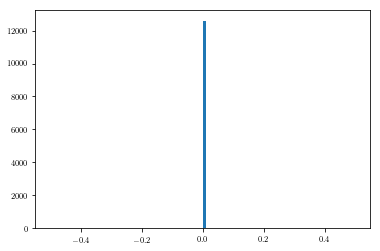

In [11]:
plt.hist(np.ma.masked_where(nn.tmask[0,:,:]==0,np.log10(temp)).flatten(),100);
print(np.max(np.ma.masked_where(nn.tmask[0,:,:]==0,temp)))